In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df = df.drop("Time", axis=1)

In [5]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

In [6]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [7]:
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
X_train = torch.tensor(X_train.values).float().to(device)

X_test = torch.tensor(X_test.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)

In [9]:
X_train.shape

torch.Size([227845, 29])

In [10]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 29),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
for epoch in range(num_epochs):
    output = model(X_train)
    loss = criterion(output, X_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print("epoch [{}/{}], loss:{:.4f}".format(epoch + 1, num_epochs, loss.item()))

epoch [10/1000], loss:1.3309
epoch [20/1000], loss:1.3090
epoch [30/1000], loss:1.2551
epoch [40/1000], loss:1.1478
epoch [50/1000], loss:1.0988
epoch [60/1000], loss:1.0964
epoch [70/1000], loss:1.0961
epoch [80/1000], loss:1.0950
epoch [90/1000], loss:1.0919
epoch [100/1000], loss:1.0870
epoch [110/1000], loss:1.0846
epoch [120/1000], loss:1.0817
epoch [130/1000], loss:1.0764
epoch [140/1000], loss:1.0660
epoch [150/1000], loss:1.0545
epoch [160/1000], loss:1.0472
epoch [170/1000], loss:1.0418
epoch [180/1000], loss:1.0365
epoch [190/1000], loss:1.0312
epoch [200/1000], loss:1.0269
epoch [210/1000], loss:1.0222
epoch [220/1000], loss:1.0152
epoch [230/1000], loss:1.0062
epoch [240/1000], loss:0.9978
epoch [250/1000], loss:0.9905
epoch [260/1000], loss:0.9841
epoch [270/1000], loss:0.9781
epoch [280/1000], loss:0.9718
epoch [290/1000], loss:0.9648
epoch [300/1000], loss:0.9592
epoch [310/1000], loss:0.9541
epoch [320/1000], loss:0.9495
epoch [330/1000], loss:0.9461
epoch [340/1000], l

In [12]:
def predict_fraud(model, data):
    predictions = model(data)
    reconstruction_errors = (
        torch.mean((predictions - data) ** 2, dim=1).cpu().detach().numpy()
    )
    threshold = np.quantile(reconstruction_errors, 0.99)
    prediction = (reconstruction_errors > threshold).astype(int)
    return prediction

[[56346   518]
 [   46    52]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     56864
         1.0       0.09      0.53      0.16        98

    accuracy                           0.99     56962
   macro avg       0.55      0.76      0.58     56962
weighted avg       1.00      0.99      0.99     56962

0.7607513953808873


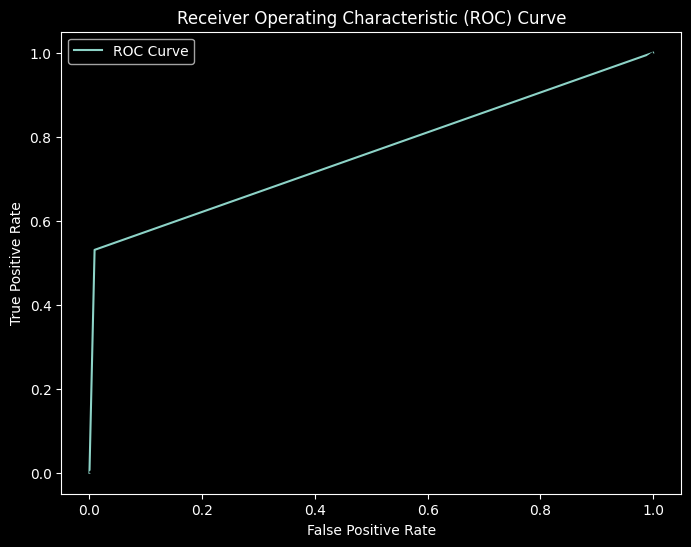

[0.00172045 0.09122807 1.        ] [1.         0.53061224 0.        ] [0 1]


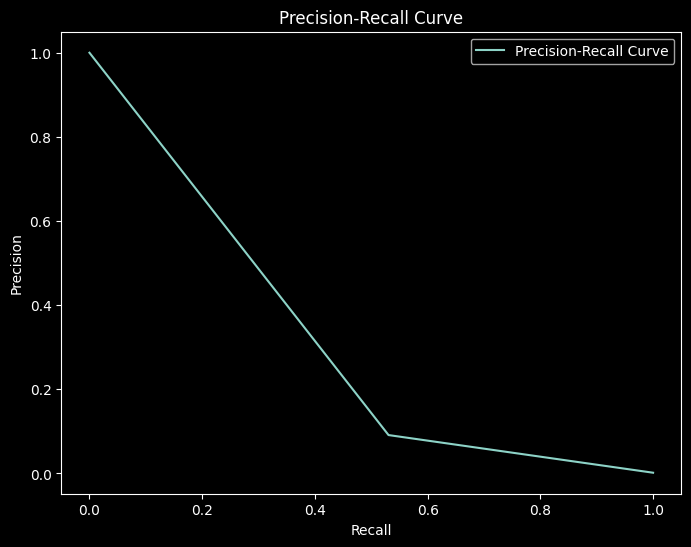

In [ ]:
y_pred = predict_fraud(model, X_test)
print(confusion_matrix(y_test.cpu(), y_pred))
print(classification_report(y_test.cpu(), y_pred))
print(roc_auc_score(y_test.to('cpu'), y_pred))
roc_auc = roc_curve(y_test.to('cpu'), y_pred)
plt.figure(figsize=(8, 6))
plt.plot(roc_auc[0], roc_auc[1], label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test.to('cpu'), y_pred)
print(precision, recall, thresholds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()